In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
#import modin.pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
from sklearn.decomposition import PCA

In [8]:
import pandas as pd
#bikers
bikers = pd.read_csv("DAta/bikers.csv")
bikers = bikers.set_index('biker_id')
bikers = bikers.drop(columns = ["language_id",'location_id','time_zone','gender','bornIn','member_since'])
#bikers = bikers.rename(columns = {"language_id":"lat","location_id":"lon"})

#network 
network = pd.read_csv("DAta/bikers_network.csv")
network = network.set_index('biker_id')


#tour convoy
convoy = pd.read_csv("DAta/tour_convoy.csv").set_index("tour_id")

#location 
locs = pd.read_csv("DAta/locations.csv").drop(columns = ['Unnamed: 0']).rename(columns = {"latitude":"lat","longitude":'lon'})
locs = locs.set_index('biker_id')


test = pd.read_csv("DAta/test.csv")

train = pd.read_csv("DAta/train.csv")



X_train = train.drop(columns = ['like','dislike','timestamp'])
test = test.drop(columns = ['timestamp'])

In [ ]:
import modin.pandas as pd
tours = pd.read_csv("DAta/tours.csv")
tours = tours.rename(columns = {"w_other":"w101"})

In [9]:
train_copy = train.copy()

#invite == 1
for i in range(len(train_copy)):
    if train_copy['invited'][i] == 1:
        if train_copy['like'][i] == 0 and train_copy['dislike'][i] == 0:
            train_copy['like'][i] = 1
            train_copy['dislike'][i] = 0
            

Y_train = np.empty(train_copy.shape[0]).reshape(-1,1)
temp1 = train_copy['like'].to_numpy()
temp2 = train_copy['dislike'].to_numpy()
for i in range(train_copy.shape[0]):
    if temp1[i] == 1:
        Y_train[i] = 1
    elif temp2[i] == 1:
        Y_train[i] = -1
    else:
        Y_train[i] = 0

                    
train_copy.insert(len(train_copy.columns),'like/dislike',Y_train.astype(int))
train_copy = train_copy.drop(columns = ['like','dislike'])

train_missing = train_copy[train_copy['like/dislike'] == 0]
train_present = train_copy[train_copy['like/dislike'] != 0]

# PCA on w's in tours

In [9]:
tours_cols = list(tours.columns)
tours_cols = tours_cols[9:]
w = tours[tours_cols]

w_num = w['w1'].to_numpy().reshape(-1,1)
for i in range(1,101):
    w_num = np.append(w_num,w['w{}'.format(i+1)].to_numpy().reshape(-1,1),axis=1)

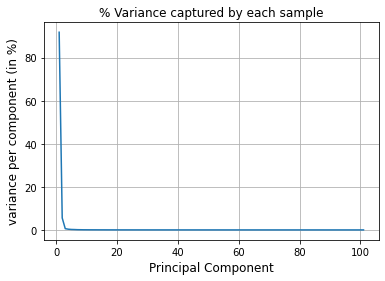

In [29]:
pca_comps = 101
pca = PCA(n_components=pca_comps)
pca.fit(w_num)
var = pca.explained_variance_ratio_

plt.plot(np.linspace(1,pca_comps,pca_comps),var*100)
plt.title("% Variance captured by each sample")
plt.xlabel("Principal Component",fontsize=12)
plt.ylabel("variance per component (in %)",fontsize=12)
plt.grid(True)
plt.show()

In [40]:
#97% of variance is captured by first 2 Principal components
np.sum(var[:2])

0.9734004495124529

In [62]:
n_comps = 2
pca = PCA(n_components=n_comps)
pca.fit(w_num)

#save the PCA model as a pickle file to be used later. uncommwnt to update model

#pickle.dump(pca,open('pca_100','wb'))

w_pca_2 = pca.transform(w_num)
# var = pca.explained_variance_ratio
temp2 = pd.DataFrame(w_pca_2,columns=['w1p', 'w2p'])



tours_cols_ = list(tours.columns)
tours_cols_ = tours_cols_[:9]
temp1 = tours[tours_cols_]



tours_mod = pd.concat([temp1, temp2], axis=1)

In [ ]:

# tours_mod.to_csv('C:/Users/Avinash/Documents/SEM 7/Pattern recognition and Machine Learning/Project/DAta/tours_mod.csv',index = True)

In [7]:
import pandas as pd
temp  = pd.read_csv("DAta/tours_mod.csv").drop(columns = ['city','state','pincode','country','latitude','longitude','tour_date'])
temp.head(5)

,tour_id,biker_id,x1p,x2p
0,VX4921758,DG47864012,-32.818441,-0.024772
1,RT4999119,DE76440521,-34.798673,-0.019385
2,SY28440935,FB7514445,-30.030017,-0.035819
3,RU82345152,HI1585781,-33.841736,-0.022132
4,QP51165850,BA16098580,-32.846941,-0.023592


In [11]:
X_train

,biker_id,tour_id,invited
0,DA44012,QY18771225,0
1,DA44012,QU02284248,0
2,DA44012,RU29072432,0
3,DA44012,SP72478280,0
4,DA44012,QS90707377,0
...,...,...,...
13861,EC93103086,RW50873665,0
13862,EC93103086,TP84655790,0
13863,EC93103086,UY8708806,0
13864,EC93103086,VP4179853,0


# imputing 

In [18]:
import pandas as pd
tours_mod = pd.read_csv("DAta/tours_mod.csv").drop(columns = ['city','state','tour_date','country','pincode'])
tours_mod = tours_mod.rename(columns = {"x1p":"w1p","x2p":'w2p'}).set_index('tour_id')


In [23]:
#func used to impute

def find_score(biker,tour):
    org = tours_mod['biker_id'][tour]           #organizer of the given tour       

        
    #temp1 contains the list of friends of the biker
    if type(network['friends'][biker]) == str:
        temp1 = network['friends'][biker].split(" ")
    else:
        temp1 = []

            
    
    #temp2 contains a list of names of bikers not going to the given tour
    if type(convoy['not_going'][tour]) == str:
        temp2 = convoy['not_going'][tour].split(" ")
    else:
        temp2 = []
    
    #temp3 contains a list of names of bikers going to the given tour
    if type(convoy['going'][tour]) == str:
        temp3 = convoy['going'][tour].split(" ")
    else:
        temp3 = []
    
    #invitees contains a list of names of bikers invited to the given tour 
    inv_flag = False
    if convoy['invited'][tour] == 'str':
        invitees = invitees.split(" ")
        inv_flag = True
    
    
    score = 0
    for i in range(len(temp1)):                  #iterating over the list of friends of the curr biker
        
        if temp1[i] in temp3:                    #friends of given biker going to the given tour
            score += 2
        if temp1[i] in temp2:                    #friends of given biker not going to the given tour
            score -= 2
        if inv_flag and temp[i] in invitees:     #friends of given biker invited to the given tour
            score += 1
    
    #if the score is either +ve or -ve we return the sign.
    if score != 0:
        return np.sign(score)
    else:
        if org in temp1:                         #if organizer is biker's friend
            return 1


        bik_area = bikers['area'][biker]         #if tour is in the same area as the biker
        if org in bikers.index:                  
            tou_area = bikers['area'][org]
            if bik_area == tou_area:             #if the tour is in the bikers area the biker is more likely to go
                return 1
        
        
        #other tours the biker has rated 
        other_rats = train_present[train_present['biker_id'] == biker]
        if len(other_rats != 0):
            score_ = 0                           #secondary score based on the other ratings of the biker to other tours
            for j in range(len(other_rats)):
                
                #temp2_ is the list of bikers not going to one of the tours that our curr biker has rated before
                if type(convoy['not_going'][other_rats['tour_id'][other_rats.index[j]]]) == str:
                    temp2_ = convoy['not_going'][other_rats['tour_id'][other_rats.index[j]]].split(" ")
                else:
                    temp2_ = []
                
                #temp2_ is the list of bikers going to one of the tours that our curr biker has rated before
                if type(convoy['going'][other_rats['tour_id'][other_rats.index[j]]]) == str:
                    temp3_ = convoy['going'][other_rats['tour_id'][other_rats.index[j]]].split(" ")
                else:
                    temp3_ = []


                for i in range(len(temp1)):
                    if temp1[i] in temp3_:      #if bikers friend is going to the tour rated by our biker
                        score_ += 2
                    if temp1[i] in temp2_:      #if bikers friend is not going to the tour rated by our biker
                        score_ -= 2
            
            #if non zero score ,return sign of the score 
            if score_ != 0:
                return np.sign(score_)
            else:
                return -1                       #if still nothing, the biker mostly wouldnt like
        else:
            return -1                           #if our biker hasnt rated any other tour , return dislike(-1)
            
        


In [24]:
#iterating through train_missing imputing missing values using the abovee func
for i in train_missing.index:
#     print(train_missing['tour_id'][i], train_missing['biker_id'][i])
    curr_tour = train_missing['tour_id'][i]
    curr_biker = train_missing['biker_id'][i]
    train_missing['like/dislike'][i] = find_score(curr_biker,curr_tour)
    

In [31]:
train_missing = train_missing[train_missing['like/dislike']!=0]

In [36]:
train_imputed = pd.concat([train_present, train_missing], axis=0)
train_imputed

,biker_id,tour_id,invited,timestamp,like/dislike
2,DA44012,RU29072432,0,02-10-2012 15:53:05,1
7,EC36494,QU2418051,0,30-10-2012 01:48:28,1
8,EC36494,TR03627753,0,30-10-2012 01:49:14,1
10,EC36494,WY9782433,0,30-10-2012 01:48:25,1
13,FF74997,YT1853303,0,18-11-2012 21:43:36,1
...,...,...,...,...,...
13856,EC91083982,RY88656322,0,04-10-2012 10:07:33,-1
13857,EC91083982,SY5593428,0,04-10-2012 10:07:33,-1
13858,EC91083982,UT8484748,0,04-10-2012 10:07:33,-1
13859,EC91083982,UU8937896,0,04-10-2012 10:07:33,-1
